#Fine-tuning Transformers

##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -r outputs

In [0]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/utils.py ./

Copying gs://qatar_competition/utils.py...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     


In [0]:
!mkdir data
!gsutil cp -r gs://qatar_competition/data ./

mkdir: cannot create directory ‘data’: File exists
Copying gs://qatar_competition/data/all_test.csv...
Copying gs://qatar_competition/data/all_test.tsv...
Copying gs://qatar_competition/data/all_test_clean.csv...
- [3 files][107.0 KiB/107.0 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://qatar_competition/data/all_test_clean.tsv...
Copying gs://qatar_competition/data/all_training.csv...
Copying gs://qatar_competition/data/all_training.tsv...
Copying gs://qatar_competition/data/all_training_clean.csv...
Copying gs://qatar_competition/data/all_training_clean.tsv...
Copying gs://qatar_competition/data/dev.tsv...
Copying gs://qatar_competition/data/fake_test.csv...
Copying gs://qatar_competition/data/fake_training.csv...
Cop

In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [0]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5433 (delta 1), reused 3 (delta 1), pack-reused 5422
Receiving objects: 100% (5433/5433), 13.33 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (3512/3512), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-xf556dno
Created temporary directory: /tmp/pip-req-tracker-mxd2lfo7
Created requirements tracker '/tmp/pip-req-tracker-mxd2lfo7'
Created temporary directory: /tmp/pip-install-ejg6y6j9
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-v6yp57nd
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-mxd2lfo7'
    Running setup.py (p

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter


from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data/',
    'model_type':  'xlnet',
    'model_name': 'xlnet-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 10,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': True,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 4e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': 'xlnet-base-cased',
 'model_type': 'xlnet',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 10,
 'task_name': 'binary',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

ValueError: ignored

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [0]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/pytorch_transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.ef1824921bc0786e97dc88d55eb17aabf18aac90f24bd34c0650529e7ba27d6f
INFO:pytorch_transformers.modeling_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": "binary",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_pro

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/pytorch_transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.ef1824921bc0786e97dc88d55eb17aabf18aac90f24bd34c0650529e7ba27d6f
INFO:pytorch_transformers.modeling_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": 

In [0]:
model.to(device);

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    label_list = processor.get_labels()
    num_labels = len(label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [0]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data/
100%|██████████| 384/384 [00:00<00:00, 1275.28it/s]
INFO:__main__:Saving features into cached file data/cached_train_xlnet-base-cased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 384
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 480
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


0.227009Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
1.448962Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
1.906887Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
0.844672Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
1.204256Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
0.859409

INFO:__main__:Saving model checkpoint to outputs/checkpoint-10


0.634700

INFO:__main__:Saving model checkpoint to outputs/checkpoint-20


0.538501

INFO:__main__:Saving model checkpoint to outputs/checkpoint-30


0.348839

INFO:__main__:Saving model checkpoint to outputs/checkpoint-40


0.510108

Epoch:  10%|█         | 1/10 [00:17<02:40, 17.84s/it]

0.414335

INFO:__main__:Saving model checkpoint to outputs/checkpoint-50


0.073911

INFO:__main__:Saving model checkpoint to outputs/checkpoint-60


0.469711

INFO:__main__:Saving model checkpoint to outputs/checkpoint-70


0.058193

INFO:__main__:Saving model checkpoint to outputs/checkpoint-80


0.034849

INFO:__main__:Saving model checkpoint to outputs/checkpoint-90


0.202508


Epoch:  20%|██        | 2/10 [00:37<02:27, 18.40s/it]

0.488006

INFO:__main__:Saving model checkpoint to outputs/checkpoint-100


0.403540

INFO:__main__:Saving model checkpoint to outputs/checkpoint-110


0.437975

INFO:__main__:Saving model checkpoint to outputs/checkpoint-120


0.004195

INFO:__main__:Saving model checkpoint to outputs/checkpoint-130


0.604948

INFO:__main__:Saving model checkpoint to outputs/checkpoint-140


0.713875

Epoch:  30%|███       | 3/10 [00:56<02:10, 18.67s/it]

0.002740


0.406399

INFO:__main__:Saving model checkpoint to outputs/checkpoint-150


0.676212

INFO:__main__:Saving model checkpoint to outputs/checkpoint-160


0.002857

INFO:__main__:Saving model checkpoint to outputs/checkpoint-170


1.202467

INFO:__main__:Saving model checkpoint to outputs/checkpoint-180


0.032607

INFO:__main__:Saving model checkpoint to outputs/checkpoint-190


0.372521

Epoch:  40%|████      | 4/10 [01:16<01:53, 18.87s/it]

0.091540

INFO:__main__:Saving model checkpoint to outputs/checkpoint-200


0.002541

INFO:__main__:Saving model checkpoint to outputs/checkpoint-210


0.003040

INFO:__main__:Saving model checkpoint to outputs/checkpoint-220


0.001269

INFO:__main__:Saving model checkpoint to outputs/checkpoint-230


0.003619

INFO:__main__:Saving model checkpoint to outputs/checkpoint-240
Epoch:  50%|█████     | 5/10 [01:35<01:34, 18.90s/it]

0.003523

INFO:__main__:Saving model checkpoint to outputs/checkpoint-250


0.017059

INFO:__main__:Saving model checkpoint to outputs/checkpoint-260


0.005214

INFO:__main__:Saving model checkpoint to outputs/checkpoint-270


0.000627

INFO:__main__:Saving model checkpoint to outputs/checkpoint-280


0.858189

Epoch:  60%|██████    | 6/10 [01:53<01:14, 18.61s/it]

0.000736


0.854799

INFO:__main__:Saving model checkpoint to outputs/checkpoint-290


0.001119

INFO:__main__:Saving model checkpoint to outputs/checkpoint-300


0.006953

INFO:__main__:Saving model checkpoint to outputs/checkpoint-310


0.001145

INFO:__main__:Saving model checkpoint to outputs/checkpoint-320


0.001093

INFO:__main__:Saving model checkpoint to outputs/checkpoint-330


0.000929

Epoch:  70%|███████   | 7/10 [02:12<00:56, 18.83s/it]

0.000901


0.000466

INFO:__main__:Saving model checkpoint to outputs/checkpoint-340


0.002157

INFO:__main__:Saving model checkpoint to outputs/checkpoint-350


0.002829

INFO:__main__:Saving model checkpoint to outputs/checkpoint-360


0.001510

INFO:__main__:Saving model checkpoint to outputs/checkpoint-370


0.617918

INFO:__main__:Saving model checkpoint to outputs/checkpoint-380


0.001054

Epoch:  80%|████████  | 8/10 [02:31<00:37, 18.86s/it]

0.001127

INFO:__main__:Saving model checkpoint to outputs/checkpoint-390


0.001497

INFO:__main__:Saving model checkpoint to outputs/checkpoint-400


0.000685

INFO:__main__:Saving model checkpoint to outputs/checkpoint-410


0.001045

INFO:__main__:Saving model checkpoint to outputs/checkpoint-420


0.572656

INFO:__main__:Saving model checkpoint to outputs/checkpoint-430


0.001938

Epoch:  90%|█████████ | 9/10 [02:50<00:18, 18.97s/it]

0.002664


0.002925

INFO:__main__:Saving model checkpoint to outputs/checkpoint-440


0.660336

INFO:__main__:Saving model checkpoint to outputs/checkpoint-450


0.006048

INFO:__main__:Saving model checkpoint to outputs/checkpoint-460


0.500719

INFO:__main__:Saving model checkpoint to outputs/checkpoint-470


0.003001

INFO:__main__:Saving model checkpoint to outputs/checkpoint-480
Epoch: 100%|██████████| 10/10 [03:09<00:00, 19.07s/it]
INFO:__main__: global_step = 480, average loss = 0.22696199982892723


In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs/


##Evaluating

In [0]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)
        del model

INFO:__main__:Evaluate the following checkpoints: ['outputs/checkpoint-10', 'outputs/checkpoint-100', 'outputs/checkpoint-110', 'outputs/checkpoint-120', 'outputs/checkpoint-130', 'outputs/checkpoint-140', 'outputs/checkpoint-150', 'outputs/checkpoint-160', 'outputs/checkpoint-170', 'outputs/checkpoint-180', 'outputs/checkpoint-190', 'outputs/checkpoint-20', 'outputs/checkpoint-200', 'outputs/checkpoint-210', 'outputs/checkpoint-220', 'outputs/checkpoint-230', 'outputs/checkpoint-240', 'outputs/checkpoint-250', 'outputs/checkpoint-260', 'outputs/checkpoint-270', 'outputs/checkpoint-280', 'outputs/checkpoint-290', 'outputs/checkpoint-30', 'outputs/checkpoint-300', 'outputs/checkpoint-310', 'outputs/checkpoint-320', 'outputs/checkpoint-330', 'outputs/checkpoint-340', 'outputs/checkpoint-350', 'outputs/checkpoint-360', 'outputs/checkpoint-370', 'outputs/checkpoint-380', 'outputs/checkpoint-390', 'outputs/checkpoint-40', 'outputs/checkpoint-400', 'outputs/checkpoint-410', 'outputs/checkpoi

outputs/checkpoint-10


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 489.09it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 10 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 10 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs/checkpoint-100


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 450.11it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 100 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 100 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-110


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 440.12it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 110 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 110 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-120


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 491.53it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 120 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 120 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-130


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 491.01it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 130 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 130 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-140


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 392.51it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 140 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 140 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs/checkpoint-150


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 419.77it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 150 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 150 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs/checkpoint-160


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 435.50it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 160 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 160 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-170


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 418.18it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 170 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 170 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs/checkpoint-180


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 412.03it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 180 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 180 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs/checkpoint-190


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 437.11it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 190 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 190 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs/checkpoint-20


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 462.69it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 20 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs/checkpoint-200


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 413.38it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 200 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 200 *****
INFO:__main__:  fn = 2
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 24
INFO:__main__:  tp = 22



outputs/checkpoint-210


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 407.76it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 210 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 210 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs/checkpoint-220


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 411.39it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 220 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 220 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-230


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 435.03it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 230 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 230 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-240


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 429.34it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 240 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 240 *****
INFO:__main__:  fn = 2
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 24
INFO:__main__:  tp = 22



outputs/checkpoint-250


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 454.81it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 250 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 250 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-260


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 421.08it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 260 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 260 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-270


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 426.37it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 270 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 270 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-280


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 439.48it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 280 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 280 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-290


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 422.29it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 290 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 290 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-30


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 410.27it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 30 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 30 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs/checkpoint-300


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 444.65it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 300 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 300 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-310


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 436.88it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 310 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 310 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-320


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 481.03it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 320 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 320 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-330


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 528.64it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 330 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 330 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-340


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 512.57it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 340 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 340 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-350


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 509.82it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 350 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 350 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-360


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 450.34it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 360 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 360 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-370


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 486.99it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 370 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 370 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-380


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 513.36it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 380 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 380 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-390


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 485.73it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 390 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 390 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-40


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 523.62it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 40 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs/checkpoint-400


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 505.53it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 400 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 400 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-410


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 607.60it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 410 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 410 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-420


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 497.63it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 420 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 420 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24



outputs/checkpoint-430


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 511.73it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 430 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 430 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs/checkpoint-440


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 577.74it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 440 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 440 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs/checkpoint-450


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 563.76it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 450 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 450 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs/checkpoint-460


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 500.33it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 460 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 460 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs/checkpoint-470


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 526.69it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 470 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 470 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs/checkpoint-480


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 535.18it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 480 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 480 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs/checkpoint-50


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 517.12it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 50 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 50 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs/checkpoint-60


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 517.55it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 60 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs/checkpoint-70


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 499.21it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 70 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 70 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs/checkpoint-80


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 543.30it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs/checkpoint-90


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 498.49it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation 90 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 90 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 23
INFO:__main__:  tp = 24


In [0]:
results

{'fn_10': 0,
 'fn_100': 0,
 'fn_110': 0,
 'fn_120': 0,
 'fn_130': 0,
 'fn_140': 1,
 'fn_150': 0,
 'fn_160': 0,
 'fn_170': 1,
 'fn_180': 1,
 'fn_190': 0,
 'fn_20': 0,
 'fn_200': 2,
 'fn_210': 0,
 'fn_220': 0,
 'fn_230': 0,
 'fn_240': 2,
 'fn_250': 0,
 'fn_260': 0,
 'fn_270': 0,
 'fn_280': 0,
 'fn_290': 0,
 'fp_10': 0,
 'fp_100': 1,
 'fp_110': 1,
 'fp_120': 1,
 'fp_130': 1,
 'fp_140': 0,
 'fp_150': 3,
 'fp_160': 1,
 'fp_170': 0,
 'fp_180': 0,
 'fp_190': 2,
 'fp_20': 0,
 'fp_200': 0,
 'fp_210': 0,
 'fp_220': 1,
 'fp_230': 1,
 'fp_240': 0,
 'fp_250': 1,
 'fp_260': 1,
 'fp_270': 1,
 'fp_280': 1,
 'fp_290': 1,
 'mcc_10': 1.0,
 'mcc_100': 0.9591663046625439,
 'mcc_110': 0.9591663046625439,
 'mcc_120': 0.9591663046625439,
 'mcc_130': 0.9591663046625439,
 'mcc_140': 0.9591663046625439,
 'mcc_150': 0.8819171036881969,
 'mcc_160': 0.9591663046625439,
 'mcc_170': 0.9591663046625439,
 'mcc_180': 0.9591663046625439,
 'mcc_190': 0.9198662110077999,
 'mcc_20': 1.0,
 'mcc_200': 0.9198662110077999,
 'mc

In [0]:
def get_result_from_results(resutls,step="outputs"):
  fn = results["fn_"+str(step)]
  fp = results["fp_"+str(step)]
  mcc = results["mcc_"+str(step)]
  tn = results["tn_"+str(step)]
  tp = results["tp_"+str(step)]  
  return {"fn":fn,"fp":fp,"mcc":mcc,"tn":tn,"tp":tp}

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
precision,recall,accuracy,specificity,f1 = get_metrics(res)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(specificity))
print("F1: "+str(f1))

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Specificity: 1.0
F1: 1.0


In [0]:
p=[]
r=[]
a=[]
s=[]
f=[]
for i in range(10,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  res = get_result_from_results(results,i)
  precision,recall,accuracy,specificity,f1 = get_metrics(res)
  p.append(precision)
  r.append(recall)
  a.append(accuracy)
  s.append(specificity)
  f.append(f1)

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

KeyError: ignored

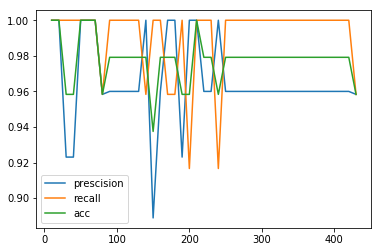

In [0]:
from matplotlib import pyplot as plt

x= range(10,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])
plt.plot(x,p,label="prescision")
plt.plot(x,r,label="recall")
plt.plot(x,a,label="acc")
#plt.plot(x,s,label="spec")
#plt.plot(x,f,label="f1")
plt.legend()
plt.show()


In [0]:
!cp ./data/dev.tsv

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
print(preds)

In [0]:
for checkpoint in checkpoints:
  global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
  model = model_class.from_pretrained(checkpoint)
  model.to(device)
  result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
  result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
  results.update(result)


In [0]:
!gsutil -m cp -r ./outputs gs://qatar_competition/outputs_xlnet_base_10epochs/

Copying file://./outputs/checkpoint-50/config.json [Content-Type=application/json]...
Copying file://./outputs/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs/checkpoint-430/config.json [Content-Type=application/json]...
Copying file://./outputs/checkpoint-480/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs/checkpoint-50/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs/checkpoint-480/config.json [Content-Type=application/json]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to ha

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv

##BERT_viz

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!mkdir ./outputs_xlnet_base/
!gsutil -m cp -r gs://qatar_competition/outputs_xlnet_base/ ./

Copying gs://qatar_competition/outputs_xlnet_base/outputs/added_tokens.json...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-100/config.json...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-200/config.json...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-100/pytorch_model.bin...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-200/pytorch_model.bin...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-50/config.json...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-150/config.json...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-50/pytorch_model.bin...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/config.json...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/checkpoint-150/pytorch_model.bin...
Copying gs://qatar_competition/outputs_xlnet_base/outputs/eval_results.txt...
Copying gs://qatar_competition/outputs_xlnet

In [0]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
!pip install sentencepiece

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 846 (delta 0), reused 1 (delta 0), pack-reused 843
Receiving objects: 100% (846/846), 58.29 MiB | 9.86 MiB/s, done.
Resolving deltas: 100% (543/543), done.
     |████████████████████████████████| 655kB 2.8MB/s 
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609234 sha256=088191d4be0b9e9f2f4d33735a8421059975c13ccf2a3abc0607a738e3a79fc5
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built regex
     |████████████████████████████████| 1.0MB 2.8MB/s 


In [0]:
from bertviz.pytorch_transformers_attn import XLNetTokenizer, XLNetModel
from bertviz.head_view import show

In [0]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [0]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
  '''))

In [0]:
!pip install pytorch_transformers
from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 860kB 45.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.34-cp36-none-any.whl size=883992 sha256=b71af5f852697c56cccbb3aaf9ab92ad53df814271e6d1227cc9bcdf80bbf9d1
  Stored in directory: /root/.cache/pip/wheels/07/b9/5b/8bd674c23e962fbff34420a9fa7a2c374d591ecadd5bc37684
Successfully built sacremoses


In [0]:
model_type = 'xlnet'
model_version = 'xlnet-base-cased'
config_class, model_class, tokenizer_class = XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer
checkpoint = "./outputs_xlnet_base/outputs/checkpoint-100/"
model = XLNetModel.from_pretrained(checkpoint)

In [0]:
tokenizer = XLNetTokenizer.from_pretrained(model_version)
text = "NASA finds Liquid Water on Mars    Liquid water might have been discovered on Mars. Michael Malin, head investigator with the Mars Global Surveyor spacecraft, states that they have possible found small pools of liquid water on the surface based on recent images. "
print(tokenizer.tokenize(text)[0:128])

['▁NASA', '▁finds', '▁Liquid', '▁Water', '▁on', '▁Mars', '▁Liquid', '▁water', '▁might', '▁have', '▁been', '▁discovered', '▁on', '▁Mars', '.', '▁Michael', '▁Mal', 'in', ',', '▁head', '▁investigator', '▁with', '▁the', '▁Mars', '▁Global', '▁Survey', 'or', '▁spacecraft', ',', '▁states', '▁that', '▁they', '▁have', '▁possible', '▁found', '▁small', '▁pools', '▁of', '▁liquid', '▁water', '▁on', '▁the', '▁surface', '▁based', '▁on', '▁recent', '▁images', '.']


In [0]:
call_html()
show(model, model_type, tokenizer, text)

In [0]:
model_type

'xlnet'

In [0]:
!gsutil du -s gs://bert_pretrain

77875202721  gs://bert_pretrain
